# UE 10 Strommarktmodell
## Ziele der Übung: Optimierungsmodell für den Kraftwerkseinsatz entwickeln
### Anforderungen
- Basic Model: Kostenoptimale Versorgung der Kunden
- Keine Repräsentation des Netzes: Strommarktmodel
- Parameter: Kosten, Leistung, Emissionen
- Betrachtung einer Periode
- Erweiterung: Betrachtung mehrerer Perioden


In [22]:
#Import Packages
from gurobipy import *
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt

## Modell Kraftwerkseinsatz


#### Grundlegende Parameter der Kraftwerke und der Nachfrage

In [23]:
#Definition der Parameter des Modells

#Leistung der Kraftwerke
Pmax_KW1 = 100 #MW
Pmin_KW1 = 25 #MW
Pmax_KW2 = 50 #MW
Pmin_KW2 = 15 #MW
#Kosten der Kraftwerke
#fix
fk_KW1 = 150 #€/h
fk_KW2 = 125 #€/h
# variabel
vk_KW1 = 60 #€/MWh
vk_KW2 = 80 #€/MWh

#### Kraftwerksemissionen

- Annahme: Ein Steinkohle und ein Gaskraftwerk
- Einfügen von Emissionen (https://www.volker-quaschning.de/datserv/CO2-spez/index.php)


In [24]:
#Emissionsfaktoren
ef_KW1 = 0.63 #tCO2/MWh
ef_KW2 = 0.35 #tCO2/MWh
e_lim = 280
#CO2-Kosten für Zertifikate
ek = 55 # €/tCO2

#### Nachfrage

In [25]:
#Nachfrage
load_min = 85 #Last in MW
load_max = 170 #Last in MW

#### Erweiterung auf mehrere Perioden

In [26]:
#Definition der Parameter des Modells für Periode 2-5
#Nachfrage
load_min_t2 = 125
load_min_t3 = 110
load_min_t4 = 90
load_min_t5 = 145

In [27]:
# list containing min_load to be covered for every period
load = [85, 125, 110, 90, 145]

In [28]:
# list containing names of powerplants
KW = ['KW1', 'KW2']

### Anlegen des Modells

In [29]:
#Create Model
M = Model('Kraftwerkseinsatz')

### Add Variables

In [30]:
# Stromproduktion der KW
x = {}
for ts in range(len(load)):
    for kw in KW:
        x[ts,kw] = M.addVar(name="x_%s,%s"%(ts,kw), vtype=GRB.CONTINUOUS)
x
M.update()

#### Zusätzliches berücksichtigen von Kraftwerksemissionen

In [31]:
# Emissionen der KW
e = {}
for ts in range(len(load)):
    for kw in KW:
        e[ts,kw] = M.addVar(name="e_%s,%s"%(ts,kw), vtype=GRB.CONTINUOUS)
M.update()

### Add Constraints

In [32]:
#Maximale Leistung der Krafwerke
for ts in range(len(load)):
    M.addConstr(x[ts,KW[0]]<=Pmax_KW1)
    M.addConstr(x[ts,KW[1]]<=Pmax_KW2)

#Minimal Leistung der Krafwerke
for ts in range(len(load)):
    M.addConstr(x[ts,KW[0]]>=Pmin_KW1)
    M.addConstr(x[ts,KW[1]]>=Pmin_KW2)

M.update()

In [33]:
#Nachfrage
for ts in range(len(load)):
    M.addConstr(x[ts,KW[0]]+x[ts,KW[1]] >=load[ts], 'Last gedeckt')

M.update()

#### Emissionslimit einführen

In [34]:
#Emissionen
for ts in range(len(load)):
        M.addConstr(e[ts,KW[0]] == x[ts,KW[0]]*ef_KW1)
        M.addConstr(e[ts,KW[1]] == x[ts,KW[1]]*ef_KW2)
M.addConstr(quicksum(e[ts,kw] for ts in range(len(load)) for kw in KW) <= e_lim)
M.update()

### Set Objective

In [35]:
M.setObjective(fk_KW1
               + fk_KW2
               + quicksum(x[ts,KW[0]]*vk_KW1 
                          + x[ts,KW[1]]*vk_KW2
                          for ts in range(len(load)))
               + quicksum(e[ts,kw]*ek
                          for ts in range(len(load))
                          for kw in KW)
              , GRB.MINIMIZE)

### Modell optimieren

In [36]:
M.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel Core Processor (Haswell, no TSX), instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36 rows, 20 columns and 60 nonzeros
Model fingerprint: 0xaea169f5
Coefficient statistics:
  Matrix range     [3e-01, 1e+00]
  Objective range  [6e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+02]
Presolve removed 30 rows and 10 columns
Presolve time: 0.02s
Presolved: 6 rows, 10 columns, 20 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.0520513e+04   1.692275e+01   0.000000e+00      0s
       7    5.3950000e+04   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.03 seconds (0.00 work units)
Optimal objective  5.395000000e+04


### Ergebnisse auslesen


In [37]:
#Attribute verschieden von Null ausgeben lassen
M.printAttr('X')


    Variable            X 
-------------------------
     x_0,KW1           35 
     x_0,KW2           50 
     x_1,KW1           75 
     x_1,KW2           50 
     x_2,KW1           60 
     x_2,KW2           50 
     x_3,KW1        41.25 
     x_3,KW2        48.75 
     x_4,KW1           95 
     x_4,KW2           50 
     e_0,KW1        22.05 
     e_0,KW2         17.5 
     e_1,KW1        47.25 
     e_1,KW2         17.5 
     e_2,KW1         37.8 
     e_2,KW2         17.5 
     e_3,KW1      25.9875 
     e_3,KW2      17.0625 
     e_4,KW1        59.85 
     e_4,KW2         17.5 


In [38]:
## get results from Optimization
values = []
names = []
# objVal = M.objVal

for v in M.getVars():
    values.append(v.X)
    names.append(v.VarName)
# return values, objVal
results = dict(zip(names, values))

In [39]:
results

{'x_0,KW1': 35.0,
 'x_0,KW2': 50.0,
 'x_1,KW1': 75.0,
 'x_1,KW2': 50.0,
 'x_2,KW1': 60.0,
 'x_2,KW2': 50.0,
 'x_3,KW1': 41.2500000000001,
 'x_3,KW2': 48.7499999999999,
 'x_4,KW1': 95.0,
 'x_4,KW2': 50.0,
 'e_0,KW1': 22.05,
 'e_0,KW2': 17.5,
 'e_1,KW1': 47.25,
 'e_1,KW2': 17.5,
 'e_2,KW1': 37.8,
 'e_2,KW2': 17.5,
 'e_3,KW1': 25.98750000000006,
 'e_3,KW2': 17.062499999999964,
 'e_4,KW1': 59.85,
 'e_4,KW2': 17.5}

In [48]:
# set dataframe for results
ppusage_df = pd.DataFrame(index=np.arange(0,5,1), columns=['usage KW 1', 'usage KW 2'], data={'usage KW 1':values[0:10:2],
                                                                                              'usage KW 2':values[1:10:2]
                                                                                             }
                         )

emissions_df = pd.DataFrame(index=np.arange(0,5,1), columns=['emissions KW 1', 'emissions KW 2'], data={'emissions KW 1':values[10:20:2],
                                                                                                        'emissions KW 2':values[11:20:2]
                                                                                                       }
                           )

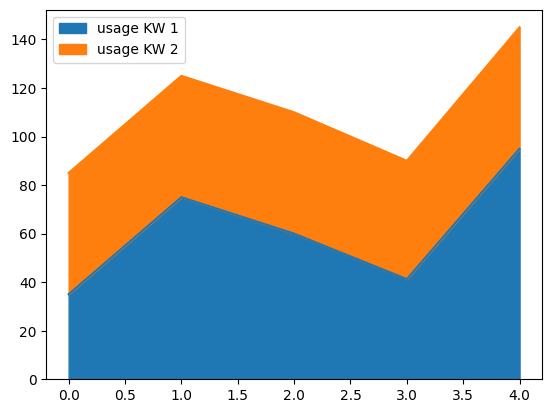

In [49]:
# visualize results, start with PP usage
ppusage_df.plot.area(stacked=True)
plt.show()

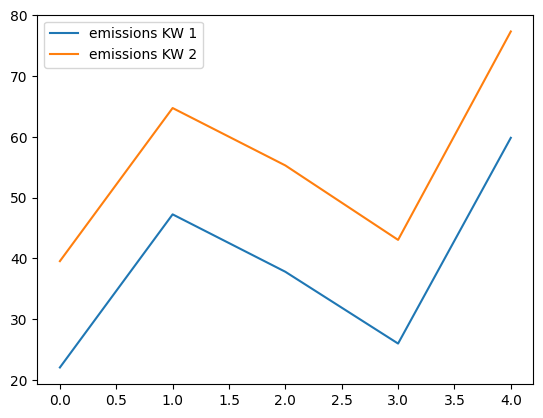

In [50]:
# visualize results, continue with emissions
emissions_df.plot(stacked=True)
plt.show()